In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score

In [2]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('Solar_Energy_Production.csv')
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
df = df.sort_values('date')

In [4]:
df.head()

,name,id,address,kWh,public_url,installationDate,uid
date,,,,,,,
2015-09-01 14:30:00,Southland Leisure Centre,164440,2000 SOUTHLAND DR SW,27.805,https://monitoring.solaredge.com/solaredge-web...,2015/09/01,1644402015-09-01 14:30:00
2015-09-01 15:30:00,Southland Leisure Centre,164440,2000 SOUTHLAND DR SW,30.559,https://monitoring.solaredge.com/solaredge-web...,2015/09/01,1644402015-09-01 15:30:00
2015-09-01 16:30:00,Southland Leisure Centre,164440,2000 SOUTHLAND DR SW,23.613,https://monitoring.solaredge.com/solaredge-web...,2015/09/01,1644402015-09-01 16:30:00
2015-09-01 17:30:00,Southland Leisure Centre,164440,2000 SOUTHLAND DR SW,15.257,https://monitoring.solaredge.com/solaredge-web...,2015/09/01,1644402015-09-01 17:30:00
2015-09-01 18:30:00,Southland Leisure Centre,164440,2000 SOUTHLAND DR SW,7.896,https://monitoring.solaredge.com/solaredge-web...,2015/09/01,1644402015-09-01 18:30:00


In [5]:
unique_id = df['id'].unique()
print('The number of unique ids are:', len(unique_id))
unique_names = df['name'].unique()
print('The number of unique locations are:', len(unique_names))
unique_address = df['address'].unique()
print('The number of unique locations are:', len(unique_address))

The number of unique ids are: 11
The number of unique locations are: 11
The number of unique locations are: 11


In [6]:
'''Since the id, address, and name points to the same, we can remove two of them. Also, public_url and uid could not be used
for the prediction. So, we can remove those columns'''
df=df.drop('id',axis=1)
df=df.drop('address',axis=1)
df=df.drop('public_url',axis=1)
df=df.drop('uid',axis=1)

In [7]:
df.head()

,name,kWh,installationDate
date,,,
2015-09-01 14:30:00,Southland Leisure Centre,27.805,2015/09/01
2015-09-01 15:30:00,Southland Leisure Centre,30.559,2015/09/01
2015-09-01 16:30:00,Southland Leisure Centre,23.613,2015/09/01
2015-09-01 17:30:00,Southland Leisure Centre,15.257,2015/09/01
2015-09-01 18:30:00,Southland Leisure Centre,7.896,2015/09/01


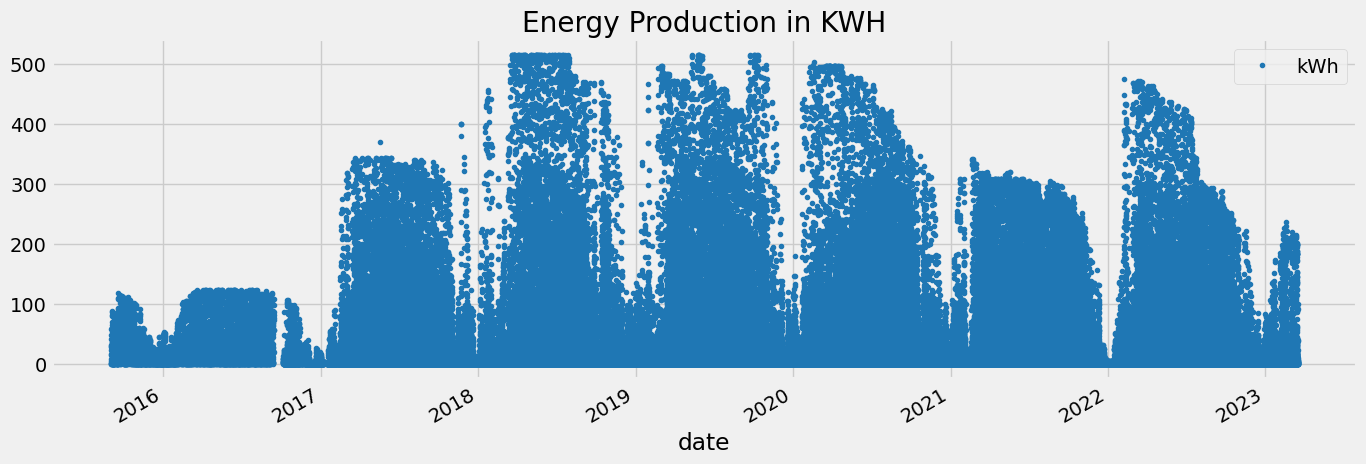

In [8]:
'''Plotting the data'''
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Energy Production in KWH')
plt.show()

We can find that the data follows a trend and the reason might be the seasonal variation of sunlight
For some years, the overall power generation was higher.

In [9]:
'''Plotting the power generation for a particular location'''
location_filter = 'Southland Leisure Centre'
filtered_df = df[df['name'] == location_filter]
filtered_df = filtered_df.sort_values('date')

In [10]:
filtered_df.iloc[-1]

name                Southland Leisure Centre
kWh                                      0.0
installationDate                  2015/09/01
Name: 2023-03-16 18:00:00, dtype: object

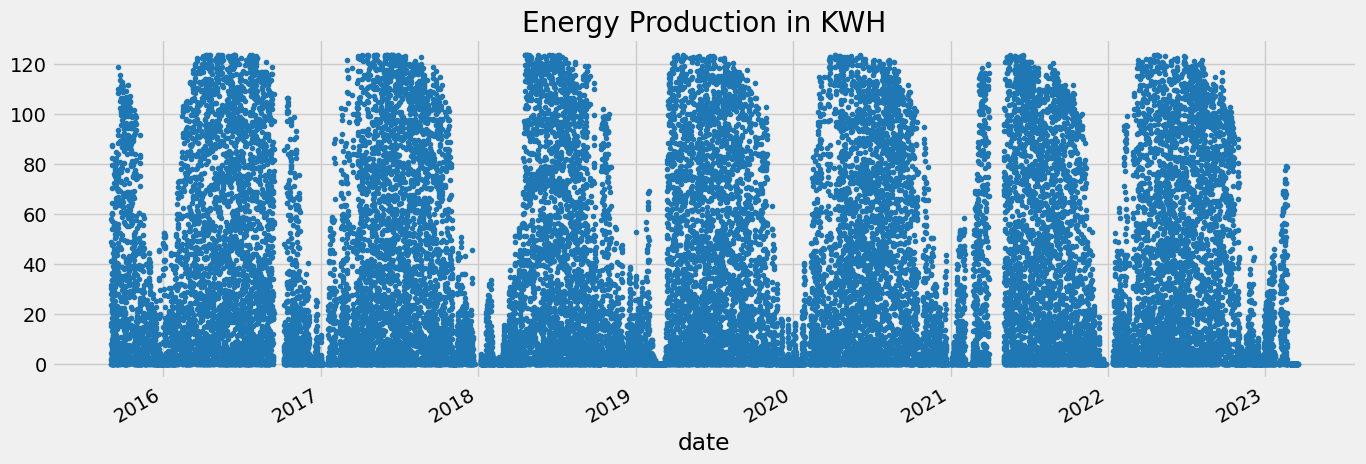

In [11]:
'''Plotting the data'''
filtered_df['kWh'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Energy Production in KWH')
plt.show()

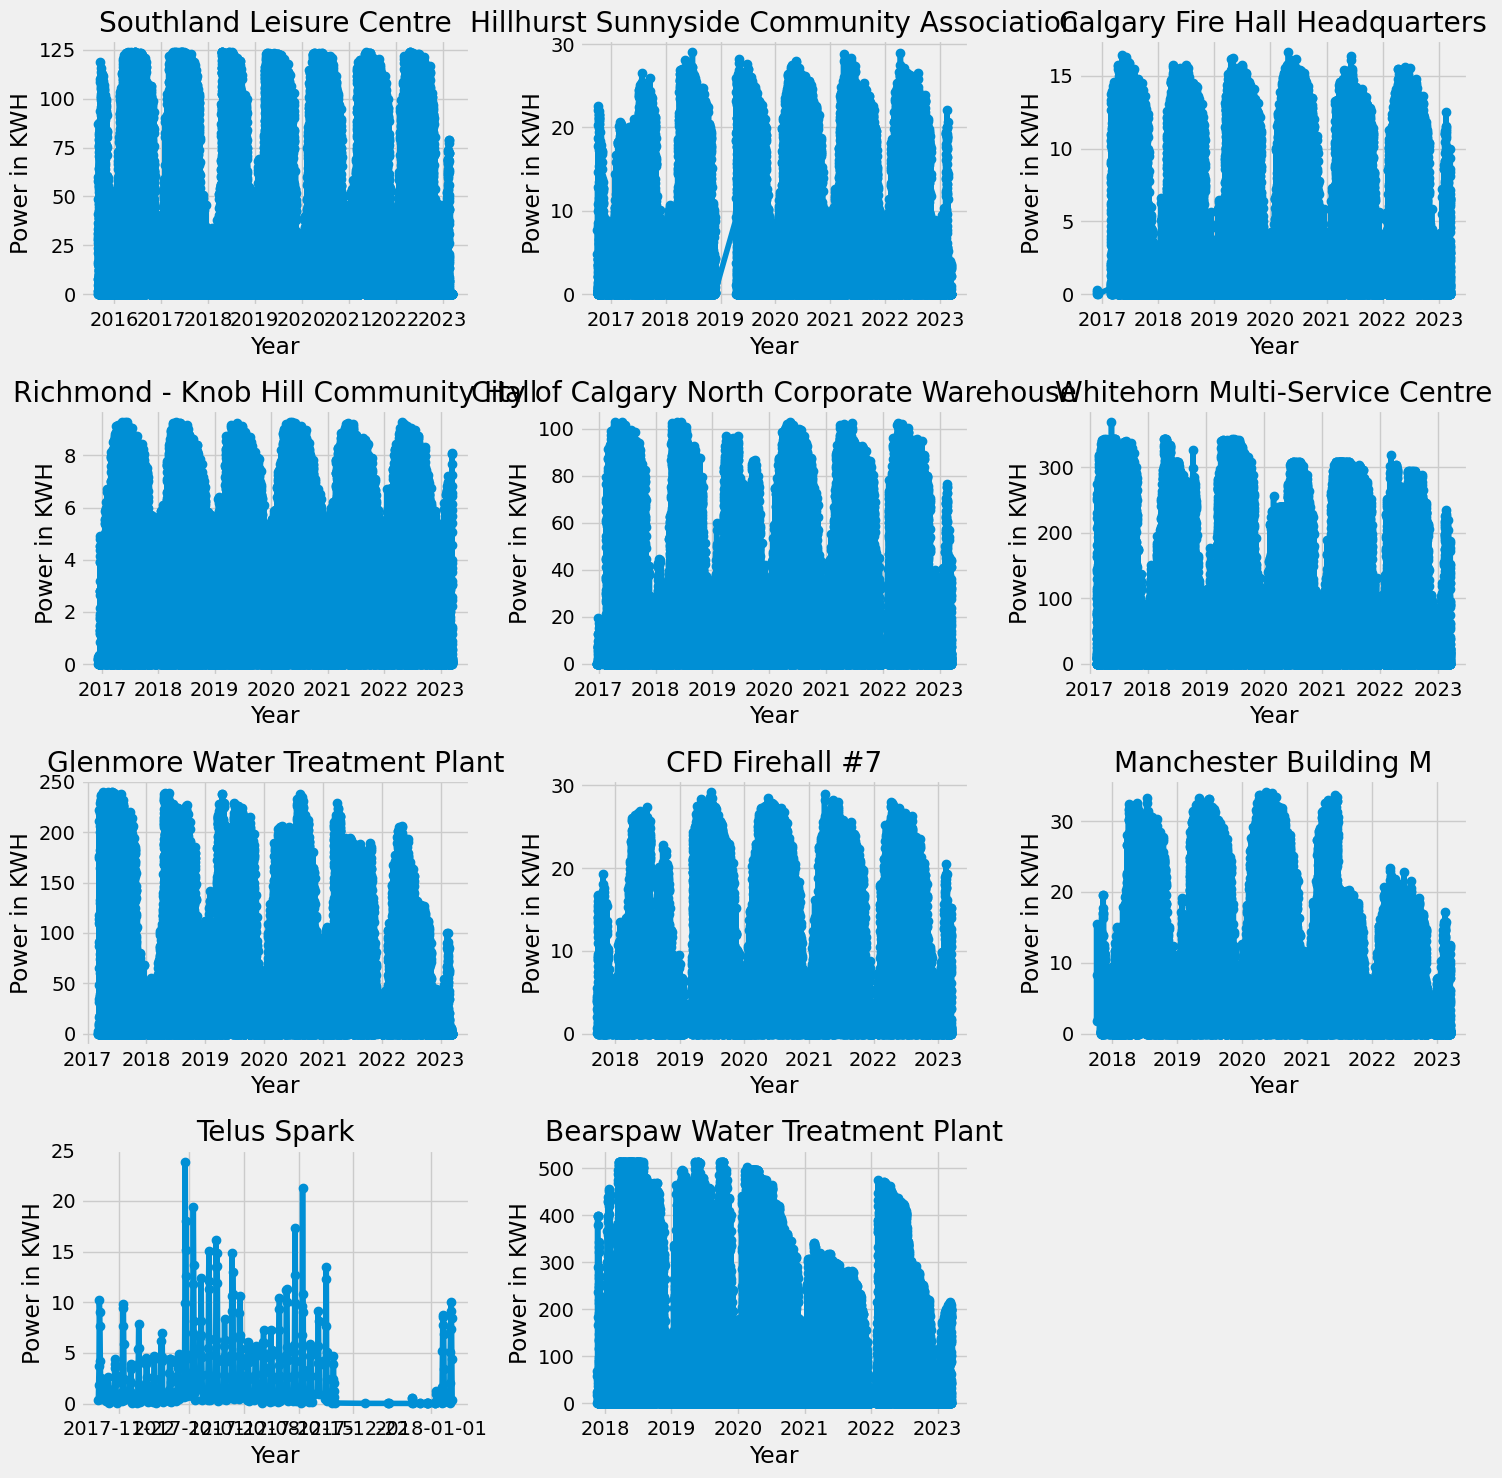

In [12]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
axs = axs.flatten()

# Plot data for each location
for i, loc in enumerate(unique_names):
    
    filtered_df = df[df['name'] == loc]
    
    axs[i].plot(filtered_df['kWh'], marker='o', linestyle='-')
    axs[i].set_title(f'{loc}')
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Power in KWH')
    axs[i].grid(True)

# Remove the unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

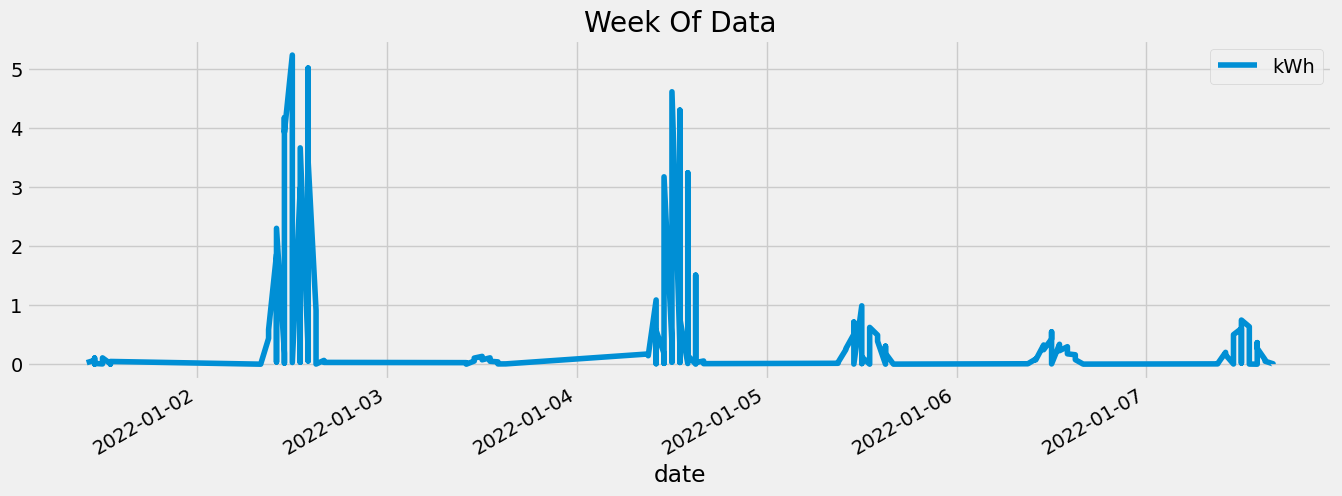

In [13]:
df.loc[(df.index > '01-01-2022') & (df.index < '01-08-2022')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [14]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df


In [15]:
df = create_features(df)
df.head()

,name,kWh,installationDate,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,,,
2015-09-01 14:30:00,Southland Leisure Centre,27.805,2015/09/01,14,1,3,9,2015,244,1,36
2015-09-01 15:30:00,Southland Leisure Centre,30.559,2015/09/01,15,1,3,9,2015,244,1,36
2015-09-01 16:30:00,Southland Leisure Centre,23.613,2015/09/01,16,1,3,9,2015,244,1,36
2015-09-01 17:30:00,Southland Leisure Centre,15.257,2015/09/01,17,1,3,9,2015,244,1,36
2015-09-01 18:30:00,Southland Leisure Centre,7.896,2015/09/01,18,1,3,9,2015,244,1,36


In [16]:
'''Days since installation could be obtained as a feature as the installation dates are given'''
df['installationDate'] = pd.to_datetime(df['installationDate'])
df['Days_Since_Installation'] = (df.index - df['installationDate']).dt.days
df

,name,kWh,installationDate,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Days_Since_Installation
date,,,,,,,,,,,,
2015-09-01 14:30:00,Southland Leisure Centre,27.805,2015-09-01,14,1,3,9,2015,244,1,36,0
2015-09-01 15:30:00,Southland Leisure Centre,30.559,2015-09-01,15,1,3,9,2015,244,1,36,0
2015-09-01 16:30:00,Southland Leisure Centre,23.613,2015-09-01,16,1,3,9,2015,244,1,36,0
2015-09-01 17:30:00,Southland Leisure Centre,15.257,2015-09-01,17,1,3,9,2015,244,1,36,0
2015-09-01 18:30:00,Southland Leisure Centre,7.896,2015-09-01,18,1,3,9,2015,244,1,36,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16 19:00:00,City of Calgary North Corporate Warehouse,0.896,2016-12-21,19,3,1,3,2023,75,16,11,2276
2023-03-16 19:00:00,CFD Firehall #7,0.259,2017-09-13,19,3,1,3,2023,75,16,11,2010
2023-03-16 19:00:00,Bearspaw Water Treatment Plant,3.102,2017-10-31,19,3,1,3,2023,75,16,11,1962


In [17]:
'''Now, we can drop the installation date column'''
df=df.drop('installationDate',axis=1)
df.head()

,name,kWh,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Days_Since_Installation
date,,,,,,,,,,,
2015-09-01 14:30:00,Southland Leisure Centre,27.805,14,1,3,9,2015,244,1,36,0
2015-09-01 15:30:00,Southland Leisure Centre,30.559,15,1,3,9,2015,244,1,36,0
2015-09-01 16:30:00,Southland Leisure Centre,23.613,16,1,3,9,2015,244,1,36,0
2015-09-01 17:30:00,Southland Leisure Centre,15.257,17,1,3,9,2015,244,1,36,0
2015-09-01 18:30:00,Southland Leisure Centre,7.896,18,1,3,9,2015,244,1,36,0


In [18]:
'''This function is used to extract periodicity of the various features of the data'''
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs)

In [19]:
df = generate_cyclical_features(df, 'hour', 24, 0)
df = generate_cyclical_features(df, 'quarter',4, 1)
df = generate_cyclical_features(df, 'month', 12, 1)
df = generate_cyclical_features(df, 'weekofyear', 52, 0)

df.head()

,name,kWh,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Days_Since_Installation,sin_hour,cos_hour,sin_quarter,cos_quarter,sin_month,cos_month,sin_weekofyear,cos_weekofyear
date,,,,,,,,,,,,,,,,,,,
2015-09-01 14:30:00,Southland Leisure Centre,27.805,14,1,3,9,2015,244,1,36,0,-0.500000,-8.660254e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 15:30:00,Southland Leisure Centre,30.559,15,1,3,9,2015,244,1,36,0,-0.707107,-7.071068e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 16:30:00,Southland Leisure Centre,23.613,16,1,3,9,2015,244,1,36,0,-0.866025,-5.000000e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 17:30:00,Southland Leisure Centre,15.257,17,1,3,9,2015,244,1,36,0,-0.965926,-2.588190e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 18:30:00,Southland Leisure Centre,7.896,18,1,3,9,2015,244,1,36,0,-1.000000,-1.836970e-16,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605


In [20]:
print(df.shape)

(258423, 19)


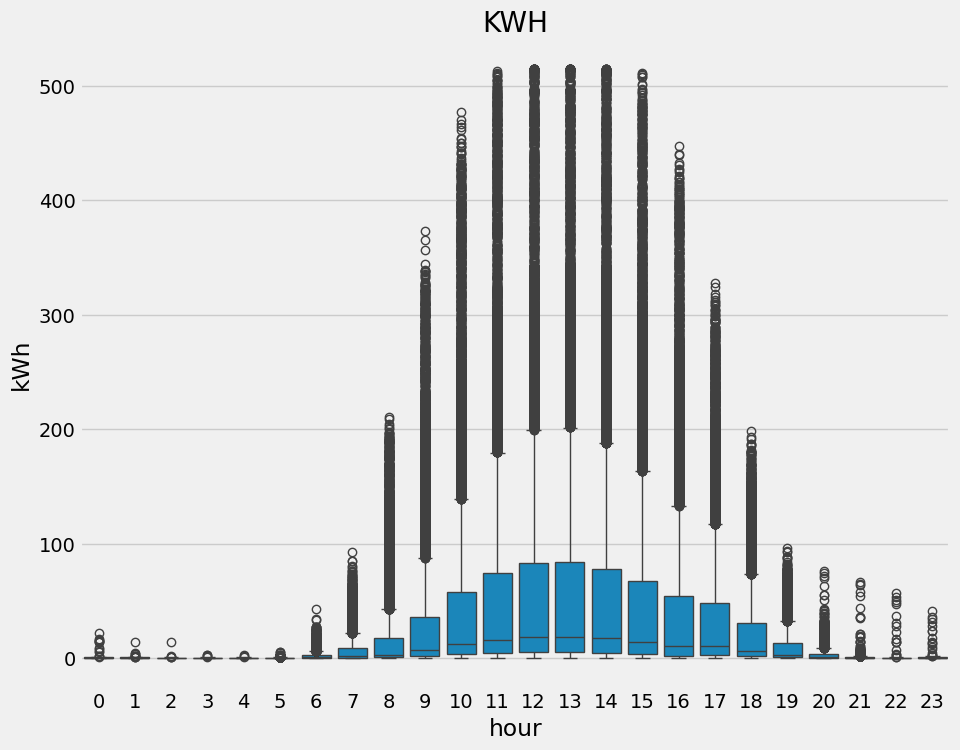

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='kWh')
ax.set_title('KWH')
plt.show()

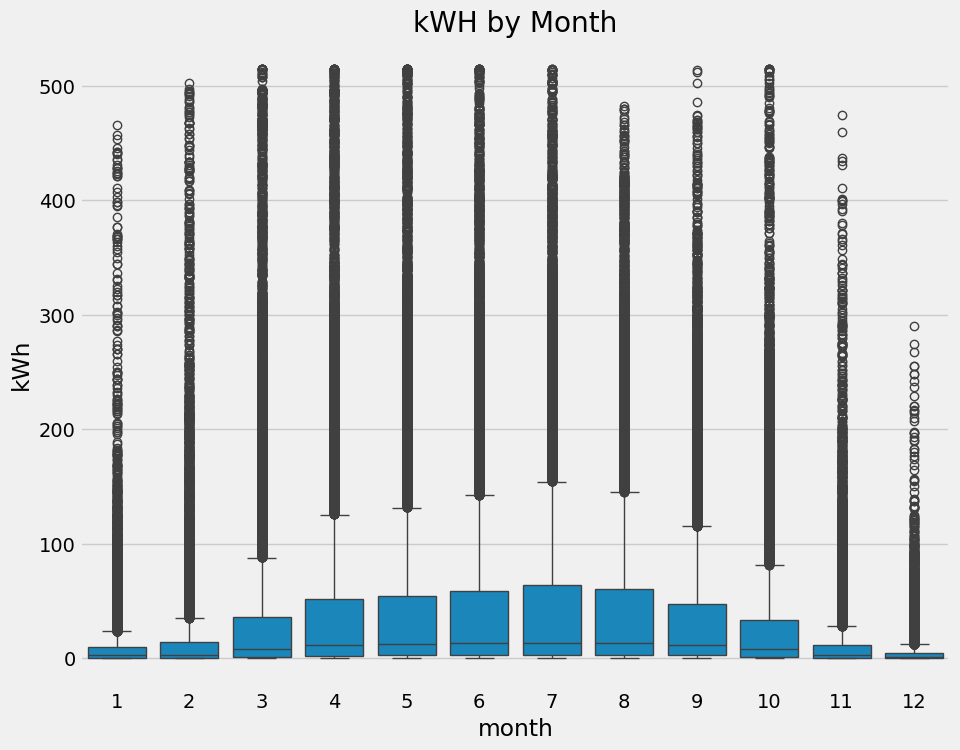

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='kWh')
ax.set_title('kWH by Month')
plt.show()

In [23]:
 '''Label-encoding for locations'''
label_encoder = LabelEncoder()
df['name'] = label_encoder.fit_transform(df['name'])
df.head()

,name,kWh,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Days_Since_Installation,sin_hour,cos_hour,sin_quarter,cos_quarter,sin_month,cos_month,sin_weekofyear,cos_weekofyear
date,,,,,,,,,,,,,,,,,,,
2015-09-01 14:30:00,8,27.805,14,1,3,9,2015,244,1,36,0,-0.500000,-8.660254e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 15:30:00,8,30.559,15,1,3,9,2015,244,1,36,0,-0.707107,-7.071068e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 16:30:00,8,23.613,16,1,3,9,2015,244,1,36,0,-0.866025,-5.000000e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 17:30:00,8,15.257,17,1,3,9,2015,244,1,36,0,-0.965926,-2.588190e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 18:30:00,8,7.896,18,1,3,9,2015,244,1,36,0,-1.000000,-1.836970e-16,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605


In [24]:
train = df.loc[df.index < '01-01-2022']
test = df.loc[df.index >= '01-01-2022']

In [25]:
print(len(train))
print(len(test))
print(len(df))

209740
48683
258423


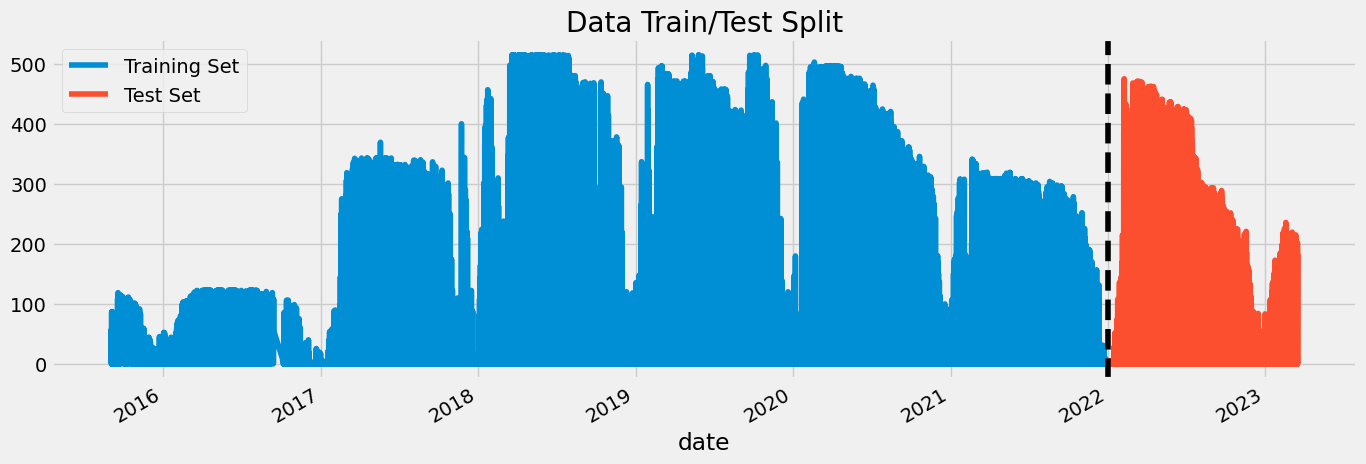

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))
train['kWh'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['kWh'].plot(ax=ax, label='Test Set')
ax.axvline('01-01-2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [27]:
features =  df.columns.tolist()
target = features.pop(1)
print(features)
print(target)

['name', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'Days_Since_Installation', 'sin_hour', 'cos_hour', 'sin_quarter', 'cos_quarter', 'sin_month', 'cos_month', 'sin_weekofyear', 'cos_weekofyear']
kWh


In [28]:
x_train = train[features]
y_train = train[target]

x_test = test[features]
y_test = test[target]

In [48]:
print(x_train.shape)
x_train.head()

(209740, 18)


,name,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Days_Since_Installation,sin_hour,cos_hour,sin_quarter,cos_quarter,sin_month,cos_month,sin_weekofyear,cos_weekofyear
date,,,,,,,,,,,,,,,,,,
2015-09-01 14:30:00,8,14,1,3,9,2015,244,1,36,0,-0.500000,-8.660254e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 15:30:00,8,15,1,3,9,2015,244,1,36,0,-0.707107,-7.071068e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 16:30:00,8,16,1,3,9,2015,244,1,36,0,-0.866025,-5.000000e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 17:30:00,8,17,1,3,9,2015,244,1,36,0,-0.965926,-2.588190e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605
2015-09-01 18:30:00,8,18,1,3,9,2015,244,1,36,0,-1.000000,-1.836970e-16,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605


In [30]:
y_train.head()

date
2015-09-01 14:30:00    27.805
2015-09-01 15:30:00    30.559
2015-09-01 16:30:00    23.613
2015-09-01 17:30:00    15.257
2015-09-01 18:30:00     7.896
Name: kWh, dtype: float64

In [31]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=2000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:82.01742	validation_1-rmse:72.92692


/home/user/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [04:06:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:57.47274	validation_1-rmse:48.05178
[200]	validation_0-rmse:49.73178	validation_1-rmse:41.60588
[300]	validation_0-rmse:46.12796	validation_1-rmse:39.03998
[400]	validation_0-rmse:43.62890	validation_1-rmse:37.50258
[500]	validation_0-rmse:42.23659	validation_1-rmse:36.89400
[600]	validation_0-rmse:41.32000	validation_1-rmse:36.48962
[700]	validation_0-rmse:40.72059	validation_1-rmse:36.23530
[800]	validation_0-rmse:40.28355	validation_1-rmse:36.02009
[900]	validation_0-rmse:39.97636	validation_1-rmse:35.93304
[1000]	validation_0-rmse:39.67002	validation_1-rmse:35.85868
[1100]	validation_0-rmse:39.44398	validation_1-rmse:35.82606
[1193]	validation_0-rmse:39.27325	validation_1-rmse:35.82262


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

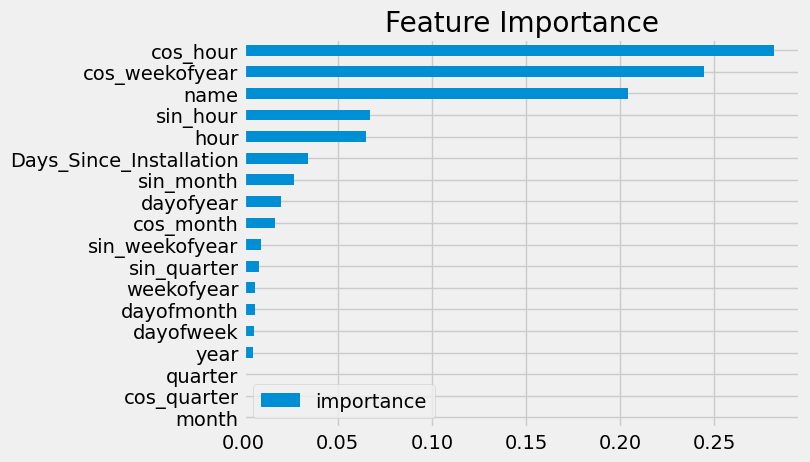

In [32]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

/tmp/ipykernel_2878656/2954275634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(x_test)


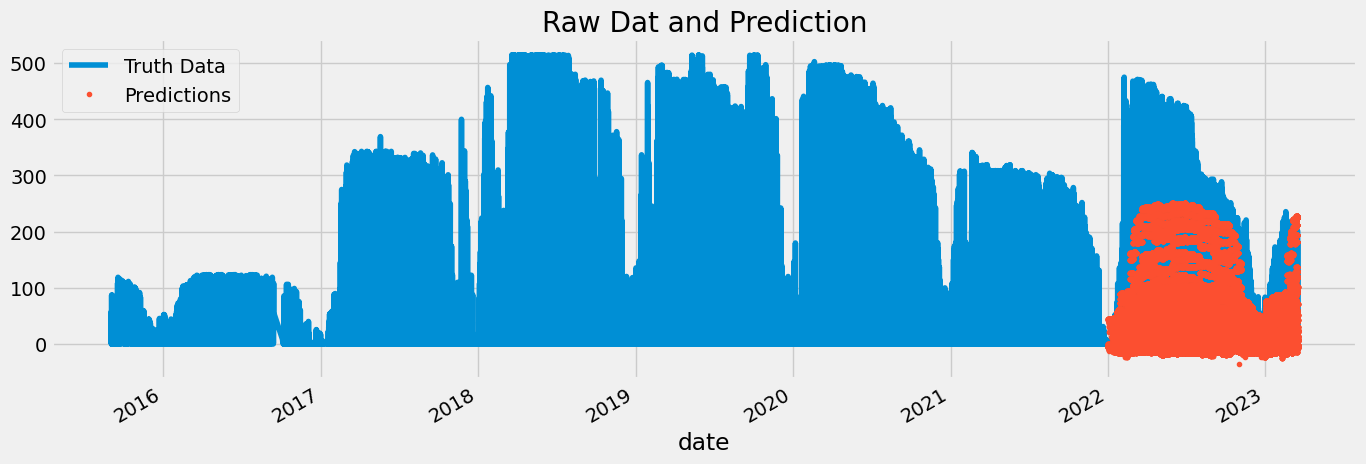

In [33]:
test['prediction'] = reg.predict(x_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['kWh']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [34]:
test

,name,kWh,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Days_Since_Installation,sin_hour,cos_hour,sin_quarter,cos_quarter,sin_month,cos_month,sin_weekofyear,cos_weekofyear,prediction
date,,,,,,,,,,,,,,,,,,,,
2022-01-01 10:00:00,6,0.026,10,5,1,1,2022,1,1,52,1531,0.500000,-0.866025,0.0,1.0,0.000000,1.0,0.0,1.0,-6.403500
2022-01-01 11:00:00,4,0.067,11,5,1,1,2022,1,1,52,1816,0.258819,-0.965926,0.0,1.0,0.000000,1.0,0.0,1.0,43.236767
2022-01-01 11:00:00,6,0.105,11,5,1,1,2022,1,1,52,1531,0.258819,-0.965926,0.0,1.0,0.000000,1.0,0.0,1.0,-1.512545
2022-01-01 11:00:00,7,0.003,11,5,1,1,2022,1,1,52,1867,0.258819,-0.965926,0.0,1.0,0.000000,1.0,0.0,1.0,-5.564842
2022-01-01 11:00:00,5,0.014,11,5,1,1,2022,1,1,52,1924,0.258819,-0.965926,0.0,1.0,0.000000,1.0,0.0,1.0,-4.330652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16 19:00:00,3,0.896,19,3,1,3,2023,75,16,11,2276,-0.965926,0.258819,0.0,1.0,0.866025,0.5,0.970942,0.239316,8.528599
2023-03-16 19:00:00,1,0.259,19,3,1,3,2023,75,16,11,2010,-0.965926,0.258819,0.0,1.0,0.866025,0.5,0.970942,0.239316,-5.822211
2023-03-16 19:00:00,0,3.102,19,3,1,3,2023,75,16,11,1962,-0.965926,0.258819,0.0,1.0,0.866025,0.5,0.970942,0.239316,22.631351


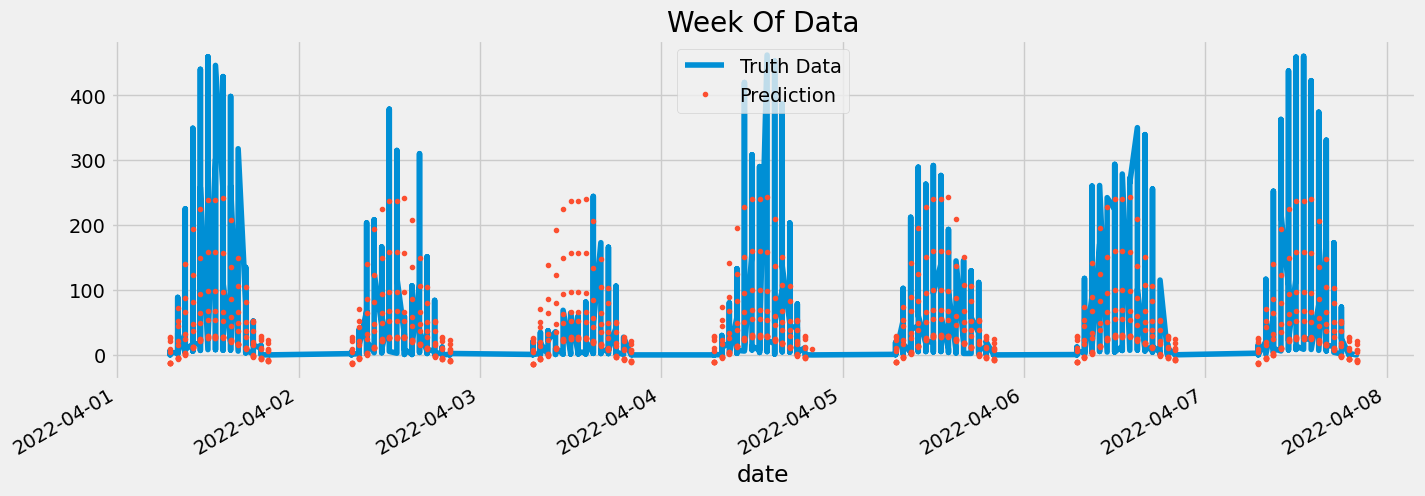

In [35]:
ax = test.loc[(test.index > '04-01-2022') & (test.index < '04-08-2022')]['kWh'] \
    .plot(figsize=(15, 5), title='Week Of Data')
test.loc[(test.index > '04-01-2022') & (test.index < '04-08-2022')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [36]:
df.head()

,name,kWh,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Days_Since_Installation,sin_hour,cos_hour,sin_quarter,cos_quarter,sin_month,cos_month,sin_weekofyear,cos_weekofyear,prediction
date,,,,,,,,,,,,,,,,,,,,
2015-09-01 14:30:00,8,27.805,14,1,3,9,2015,244,1,36,0,-0.500000,-8.660254e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,NaN
2015-09-01 15:30:00,8,30.559,15,1,3,9,2015,244,1,36,0,-0.707107,-7.071068e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,NaN
2015-09-01 16:30:00,8,23.613,16,1,3,9,2015,244,1,36,0,-0.866025,-5.000000e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,NaN
2015-09-01 17:30:00,8,15.257,17,1,3,9,2015,244,1,36,0,-0.965926,-2.588190e-01,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,NaN
2015-09-01 18:30:00,8,7.896,18,1,3,9,2015,244,1,36,0,-1.000000,-1.836970e-16,1.224647e-16,-1.0,-0.866025,-0.5,-0.935016,-0.354605,NaN


In [37]:
score = np.sqrt(mean_squared_error(test['kWh'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 35.82


In [40]:
test['error'] = np.abs(test[target] - test['prediction'])
test['dates'] = test.index.date

In [41]:
test.head()

,name,kWh,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,cos_hour,sin_quarter,cos_quarter,sin_month,cos_month,sin_weekofyear,cos_weekofyear,prediction,error,dates
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01 10:00:00,6,0.026,10,5,1,1,2022,1,1,52,...,-0.866025,0.0,1.0,0.0,1.0,0.0,1.0,-6.403500,6.429500,2022-01-01
2022-01-01 11:00:00,4,0.067,11,5,1,1,2022,1,1,52,...,-0.965926,0.0,1.0,0.0,1.0,0.0,1.0,43.236767,43.169767,2022-01-01
2022-01-01 11:00:00,6,0.105,11,5,1,1,2022,1,1,52,...,-0.965926,0.0,1.0,0.0,1.0,0.0,1.0,-1.512545,1.617545,2022-01-01
2022-01-01 11:00:00,7,0.003,11,5,1,1,2022,1,1,52,...,-0.965926,0.0,1.0,0.0,1.0,0.0,1.0,-5.564842,5.567842,2022-01-01
2022-01-01 11:00:00,5,0.014,11,5,1,1,2022,1,1,52,...,-0.965926,0.0,1.0,0.0,1.0,0.0,1.0,-4.330652,4.344652,2022-01-01


In [46]:
a = r2_score(test['kWh'], test['prediction'])
print(a)

0.696853040050852
